In [1]:
import os
import dotenv
from langchain_groq import ChatGroq
from langgraph.graph import START, END, MessagesState, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from langchain_openai import ChatOpenAI

dotenv.load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [2]:
## DEFINE YOUR TOOLS

def add(a:int, b:int)-> int:
    """Adds two integer
    """
    return a+b

def multiply(a:int, b:int)-> int:
    """Multiplies two integer
    """
    return a*b

def divide(a:int, b:int)-> int:
    """Divides two integer
    """
    return a/b

tools = [add,multiply,divide]

In [3]:

# STEP 1 DEFINE LLM
llm_with_tools = ChatGroq(model='qwen-2.5-32b').bind_tools(tools=tools)

# llm_with_tools=ChatOpenAI(model="gpt-4o")



In [4]:
# STEP 2 CREATE GRAPH

sys_msg = SystemMessage(content="You are a helpful assistant expert in arithmetic calculations.")
def assistant(state:MessagesState):
    return {"messages":llm_with_tools.invoke([sys_msg] + state["messages"])}

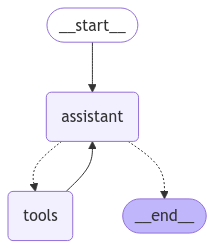

In [5]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("assistant", assistant)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_edge(START, 'assistant')
graph_builder.add_conditional_edges('assistant', tools_condition)

graph_builder.add_edge("tools","assistant")
# graph_builder.add_edge('tools', END)
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [6]:
msg = [HumanMessage(content="Add 10 and 14. Multiply the output by 2. Divide the output by 5")]
messages = graph.invoke({"messages":msg})
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Add 10 and 14. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_c0zx)
 Call ID: call_c0zx
  Args:
    a: 10
    b: 14
  multiply (call_t5be)
 Call ID: call_t5be
  Args:
    a: 24
    b: 2
  divide (call_g1xs)
 Call ID: call_g1xs
  Args:
    a: 48
    b: 5
================================= Tool Message =================================
Name: add

24
================================= Tool Message =================================
Name: multiply

48
================================= Tool Message =================================
Name: divide

9.6
================================== Ai Message ==================================

The final result after performing the operations is 9.6.


In [13]:
msg = [HumanMessage(content="Add 10 and 14")]
messages = graph.invoke({"messages":msg})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 14
================================== Ai Message ==================================
Tool Calls:
  add (call_r2mn)
 Call ID: call_r2mn
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================

The sum of 10 and 14 is 24.


In [14]:
msg = [HumanMessage(content="Multiply the output by 2")]
messages = graph.invoke({"messages":msg})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply the output by 2
================================== Ai Message ==================================

To proceed with your request, I need to know the initial values or the output you want to multiply by 2. Could you please provide those details?


## Memory Saver in Agents

In [15]:
# Creating checkpoints in every interactions
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver() # create connection with SQL and other dbs 

react_graph = graph_builder.compile(checkpointer=memory) # it will refer to this memory, checkpointer is created as object of memory ; cp also saves states as well



In [16]:
config = {"configurable":{"thread_id":1}} # we are creating session variables for the config

# specify messages
msg = [HumanMessage(content="Add 3 and 4")]
messages = react_graph.invoke({"messages":msg}, config=config) # config maintains the session

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_fwfy)
 Call ID: call_fwfy
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [17]:
msg = [HumanMessage(content="Multiply the output by 2")]
messages = react_graph.invoke({"messages":msg}, config=config) # config maintains the session

for m in messages['messages']:
    m.pretty_print()

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool_call>\n{"name": "multiply", "arguments": "{\\"a\\": 7, \\"b\\": 2}"}\n</tool_call>'}}

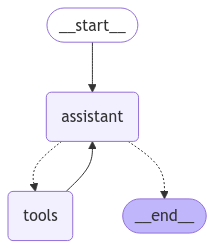

In [24]:
display(Image(g.get_graph().draw_mermaid_png()))